# Assignment 4: Wheres Waldo?
### Name: Eileanor LaRocco
In this assignment, you will develop an object detection algorithm to locate Waldo in a set of images. You will develop a model to detect the bounding box around Waldo. Your final task is to submit your predictions on Kaggle for evaluation.

### Imports

In [2]:
import os
import opendatasets as od
import pandas as pd
import numpy as np
import random
import csv
import matplotlib.pyplot as plt

import shutil
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.utils.data import DataLoader
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image

In [3]:
SEED = 1

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = device = torch.device("cuda") #mps/cuda
print(device)

cuda


### Paths

In [4]:
train_folder = "2024-fall-ml-3-hw-4-wheres-waldo/train/train" # Original Train Images
test_folder = "2024-fall-ml-3-hw-4-wheres-waldo/test/test" # Original Test Images
annotations_file = "2024-fall-ml-3-hw-4-wheres-waldo/annotations.csv" # Original Annotations File
image_sz = 512

In [5]:
# Define the dataset (Train and Test Loaders)
class WaldoDataset(torch.utils.data.Dataset):
    def __init__(self, annotations_file, img_dir, transforms=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transforms = transforms

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path).convert("RGB")
        #image = torchvision.transforms.ToTensor()(image)  # Convert to tensor
        
        box_data = self.img_labels.iloc[idx, 1:].values
        boxes = [float(item) for item in box_data]
        
        boxes = torch.as_tensor([boxes], dtype=torch.float32)
        labels = torch.ones((1,), dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((1,), dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            image = self.transforms(image)

        return image, target


# Set up the dataset and data loaders
train_dataset = WaldoDataset(
    annotations_file="2024-fall-ml-3-hw-4-wheres-waldo/train_annotations.csv",
    img_dir="2024-fall-ml-3-hw-4-wheres-waldo/train/chunks",
    transforms=torchvision.transforms.Compose([
        torchvision.transforms.Resize((image_sz, image_sz)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
)

val_dataset = WaldoDataset(
    annotations_file="2024-fall-ml-3-hw-4-wheres-waldo/test_annotations.csv",
    img_dir="2024-fall-ml-3-hw-4-wheres-waldo/train/val",
    transforms=torchvision.transforms.Compose([
        torchvision.transforms.Resize((image_sz, image_sz)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
)

train_data_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    collate_fn=lambda x: list(zip(*x))
)

val_data_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    collate_fn=lambda x: list(zip(*x))
)


# Model

### Architecture

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.ops import RoIAlign
import torchvision.ops as ops

device = device = torch.device("cuda")

def decode_boxes(deltas, anchors):
    """
    Decode bounding box deltas to proposals.

    Args:
        deltas: [num_anchors, 4] Predicted bbox deltas (dx, dy, dw, dh).
        anchors: [num_anchors, 4] Anchor boxes (x1, y1, x2, y2).

    Returns:
        decoded_boxes: [num_anchors, 4] Decoded boxes in (x1, y1, x2, y2) format.
    """
    # Convert anchors to center format (cx, cy, w, h)
    anchors = ops.box_convert(anchors, in_fmt="xyxy", out_fmt="cxcywh")
    anchor_cx, anchor_cy, anchor_w, anchor_h = anchors.split(1, dim=1)

    # Decode deltas
    dx, dy, dw, dh = deltas.split(1, dim=1)
    pred_cx = dx * anchor_w + anchor_cx
    pred_cy = dy * anchor_h + anchor_cy
    pred_w = torch.exp(dw) * anchor_w
    pred_h = torch.exp(dh) * anchor_h

    # Convert back to (x1, y1, x2, y2)
    decoded_boxes = torch.cat([
        pred_cx - 0.5 * pred_w,  # x1
        pred_cy - 0.5 * pred_h,  # y1
        pred_cx + 0.5 * pred_w,  # x2
        pred_cy + 0.5 * pred_h   # y2
    ], dim=1)

    return decoded_boxes


def generate_anchors(base_size, scales, aspect_ratios, feature_size, stride, device):
    """
    Generate anchors for the feature map.

    Args:
        base_size (int): Base size of the anchors.
        scales (list of float): Scaling factors for the anchors.
        aspect_ratios (list of float): Aspect ratios (width/height) for the anchors.
        feature_size (tuple of int): Feature map size (height, width).
        stride (int): Stride of the feature map relative to the input image.

    Returns:
        anchors (torch.Tensor): [num_anchors, 4] Anchor boxes (x1, y1, x2, y2).
    """
    anchors = []
    for y in range(feature_size[0]):
        for x in range(feature_size[1]):
            cx = x * stride + stride / 2  # Center x
            cy = y * stride + stride / 2  # Center y
            for scale in scales:
                for ratio in aspect_ratios:
                    w = base_size * scale * (ratio ** 0.5)
                    h = base_size * scale / (ratio ** 0.5)
                    anchors.append([cx - w / 2, cy - h / 2, cx + w / 2, cy + h / 2])
    anchors = torch.tensor(anchors, dtype=torch.float32, device=device)
    return anchors


def generate_proposals(rpn_cls_logits, rpn_bbox_preds, anchors, image_size, device, top_n=1):
    batch_size = rpn_cls_logits.size(0)
    proposals = []

    for b in range(batch_size):
        # Flatten predictions and anchors
        cls_logits = rpn_cls_logits[b].permute(1, 2, 0).reshape(-1, 2)
        bbox_preds = rpn_bbox_preds[b].permute(1, 2, 0).reshape(-1, 4)
        
        # Apply softmax to classification logits
        scores = F.softmax(cls_logits, dim=-1)[:, 1]  # Keep "objectness" score
        
        # Decode predicted deltas to proposals
        decoded_boxes = decode_boxes(bbox_preds, anchors)
        
        # Clip proposals to image boundaries
        decoded_boxes = ops.clip_boxes_to_image(decoded_boxes, image_size)
        
        # Filter proposals by score and apply NMS
        keep = ops.nms(decoded_boxes, scores, iou_threshold=0.7)
        keep = keep[:top_n]  # Keep top_n proposals (1 in this case)
        
        # Add batch index
        batch_proposals = torch.cat(
            [torch.full((len(keep), 1), b, dtype=torch.float32, device=decoded_boxes.device), 
             decoded_boxes[keep]], 
            dim=1
        )
        proposals.append(batch_proposals)

    # Concatenate all proposals across batches
    return torch.cat(proposals, dim=0)


class SimpleRCNN(nn.Module):
    def __init__(self, num_anchors=9):
        super(SimpleRCNN, self).__init__()
        
        # Use pretrained ResNet50 as the backbone
        resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])  # Use layers up to the last conv layer
        
        # Freeze the initial layers to retain pretrained weights
        for param in list(self.backbone.parameters())[:6]:
            param.requires_grad = False

        # Region Proposal Network (RPN)
        self.rpn_conv = nn.Conv2d(2048, 512, kernel_size=3, padding=1)  # RPN Conv layer
        self.rpn_cls = nn.Conv2d(512, num_anchors * 2, kernel_size=1)  # 2 class logits per anchor (object, no object)
        self.rpn_reg = nn.Conv2d(512, num_anchors * 4, kernel_size=1)  # 4 bbox coords per anchor

        # RoI Align (assumes a fixed feature map size of 7x7 for simplicity)
        self.roi_align = RoIAlign((7, 7), spatial_scale=1.0 / 16, sampling_ratio=2)

        # Fully connected layers for classification and regression
        self.fc1 = nn.Linear(2048 * 7 * 7, 1024)
        self.fc2 = nn.Linear(1024, 4)  # Output bbox coords (x, y, w, h)

    def forward(self, x):
        # Step 1: Extract features
        features = self.backbone(x)

        # Step 2: Generate RPN outputs
        rpn_feat = F.relu(self.rpn_conv(features))
        rpn_cls_logits = self.rpn_cls(rpn_feat)
        rpn_bbox_preds = self.rpn_reg(rpn_feat)

        # Step 3: Generate anchors
        feature_size = (features.size(2), features.size(3))  # (height, width) of feature map
        stride = 16  # Assuming input image is downsampled by 16x in the backbone
        anchors = generate_anchors(base_size=16, scales=[1.0, 2.0, 0.5], aspect_ratios=[0.5, 1.0, 2.0],
                                    feature_size=feature_size, stride=stride, device=x.device)

        # Step 4: Generate proposals from RPN outputs
        proposals = generate_proposals(rpn_cls_logits, rpn_bbox_preds, anchors, x.size()[2:], device=x.device, top_n=1)

        # Step 5: Perform RoI Align
        roi_features = self.roi_align(features, proposals)

        # Step 6: Predict bounding boxes
        roi_flattened = roi_features.view(roi_features.size(0), -1)
        fc1_out = F.relu(self.fc1(roi_flattened))
        bbox = self.fc2(fc1_out)

        return bbox #, rpn_cls_logits, rpn_bbox_preds


# Example usage:
# Instantiate the model
model = SimpleRCNN()

# Example input image tensor (batch_size=1, channels=3, height=512, width=512)
input_tensor = torch.randn(1, 3, 512, 512)

# Move inputs to the same device as the model
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
input_tensor = input_tensor.to(device)

# Forward pass
bbox = model(input_tensor)

print("BBox Refinements:", bbox.shape)
print(bbox)


BBox Refinements: torch.Size([1, 4])
tensor([[ 0.0219, -0.1886,  0.2561,  0.1717]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


### Training

In [6]:
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.ops import box_iou

# Define IoU computation
def calculate_iou(pred_boxes, target_boxes):
    """
    Computes IoU between predicted and target boxes.
    Args:
        pred_boxes (Tensor): Predicted boxes, shape (N, 4).
        target_boxes (Tensor): Target boxes, shape (M, 4).
    Returns:
        IoU scores: Tensor of shape (N, M).
    """
    return ops.box_iou(pred_boxes, target_boxes)

# Training function
def train_one_epoch(model, data_loader, optimizer, device):
    model.train()
    running_loss = 0.0

    for images, targets in data_loader:
        images = torch.stack([img.to(device) for img in images])
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()

        # Forward pass
        losses = model(images, targets)

        # Ensure that losses is a dictionary and sum all loss components
        if isinstance(losses, dict):
            total_loss = sum(loss for loss in losses.values())
        else:
            raise ValueError("Expected losses to be a dictionary")

        # Backward pass and optimization
        total_loss.backward()
        optimizer.step()

        running_loss += total_loss.item()

    epoch_loss = running_loss / len(data_loader)
    return epoch_loss



# Evaluation function
def evaluate(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    total_iou = 0.0
    num_samples = 0

    with torch.no_grad():
        for images, targets in tqdm(data_loader, desc="Validation", leave=False):
            # Move data to device
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Generate predictions
            outputs = model(images)  # During evaluation, model outputs predictions
            
            # Compute IoU between predicted and target boxes
            for output, target in zip(outputs, targets):
                pred_boxes = output["boxes"].detach()
                target_boxes = target["boxes"]

                if len(pred_boxes) > 0 and len(target_boxes) > 0:
                    iou = box_iou(pred_boxes, target_boxes).mean().item()
                    total_iou += iou
                else:
                    total_iou += 0  # No predictions or no targets

                num_samples += 1

    # Calculate average IoU
    avg_iou = total_iou / num_samples if num_samples > 0 else 0.0

    return avg_iou


# Main training loop
def train_model(model, train_loader, val_loader, num_epochs, device, optimizer, scheduler, checkpoint_path):
    best_iou = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")

        # Train the model
        train_loss = train_one_epoch(model, train_loader, optimizer, device)

        # Validate the model
        val_iou = evaluate(model, val_loader, device)

        # Save the best model
        if val_iou > best_iou:
            best_iou = val_iou
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Best model saved with IoU: {best_iou:.4f}")

        # Update the learning rate
        scheduler.step()

        print(f"Training Loss: {train_loss:.4f}, Validation IoU: {val_iou:.4f}")

    print(f"Training complete. Best Validation IoU: {best_iou:.4f}")


# Set up optimizer, scheduler, and device
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, num_classes=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
checkpoint_path = "best_model.pth"
num_epochs = 10

# Train and evaluate the model
train_model(
    model,
    train_data_loader,
    val_data_loader,
    num_epochs,
    device,
    optimizer,
    scheduler,
    checkpoint_path
)


/home/ejh2wy/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ejh2wy/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/10


OutOfMemoryError: CUDA out of memory. Tried to allocate 132.00 MiB. GPU 0 has a total capacity of 44.34 GiB of which 33.06 MiB is free. Process 856841 has 35.67 GiB memory in use. Including non-PyTorch memory, this process has 8.51 GiB memory in use. Of the allocated memory 7.96 GiB is allocated by PyTorch, and 251.20 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

# Submission File 

Predicted Bounding Box: [699.23895 407.24246 700.      689.2796 ]


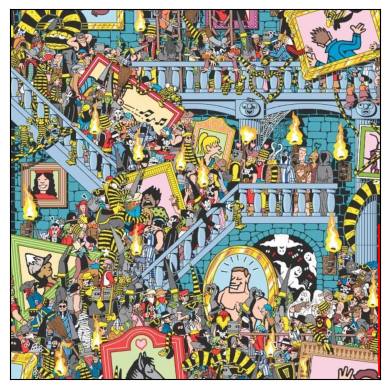

No objects detected in 2024-fall-ml-3-hw-4-wheres-waldo/test/test/1.jpg
Predicted Bounding Box: [397.91504 535.75244 446.31744 535.996  ]


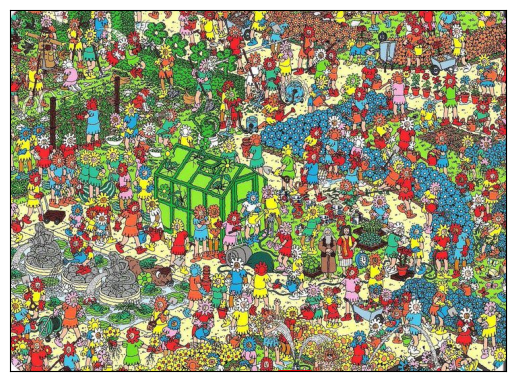

Predicted Bounding Box: [481.83    495.6575  501.73038 520.1792 ]


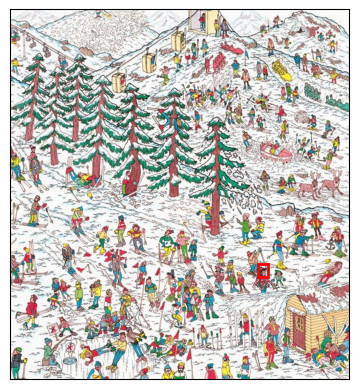

Predicted Bounding Box: [1036.8297  811.5121 1085.0371  852.8952]


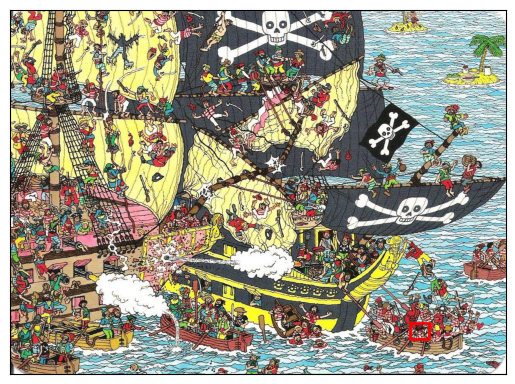

No objects detected in 2024-fall-ml-3-hw-4-wheres-waldo/test/test/2.jpg
Predicted Bounding Box: [754.8293 699.8443 811.6927 701.9184]


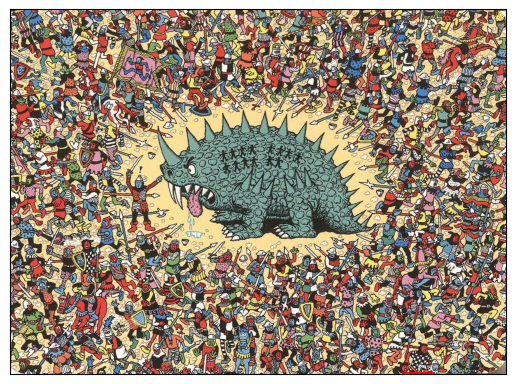

Predicted Bounding Box: [553.5786  647.5329  610.61163 647.98846]


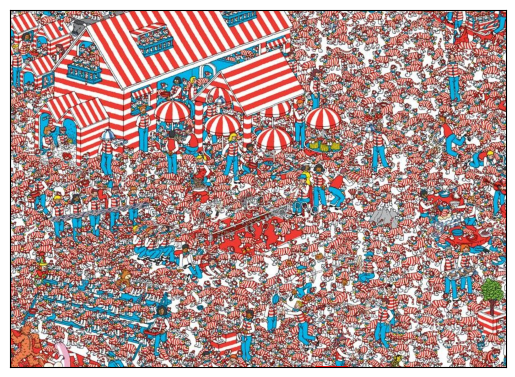

No objects detected in 2024-fall-ml-3-hw-4-wheres-waldo/test/test/3.jpg


In [20]:
predictions = []

output_directory = "2024-fall-ml-3-hw-4-wheres-waldo/outputs"
if not os.path.exists(output_directory):
        os.makedirs(output_directory)

# Function to predict bounding box on a new image
# Function to predict bounding box on a new image
# Function to predict bounding box on a new image
def predict(model, image_path, transform=None):
    model.eval()  # Set the model to evaluation mode

    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")  # Open image and convert to RGB
    orig_width, orig_height = image.size  # Get original image dimensions
    if transform:
        image = transform(image)  # Apply transformations
    image = image.unsqueeze(0)  # Add batch dimension

    # Ensure image is a Tensor and move it to the correct device
    image = image.to(device)

    # Predict the bounding box
    with torch.no_grad():
        # Get the model's output (a list of dictionaries in this case)
        outputs = model(image)
        if isinstance(outputs, list):  # Check if the output is a list
            outputs = outputs[0]  # Get the first dictionary in the list
        
        # Check if any bounding boxes were predicted
        if len(outputs['boxes']) == 0:
            print(f"No objects detected in {image_path}")
            return None  # No detection, return None or handle as needed
        
        # Extract the predicted bounding box (assuming the first detected object)
        predicted_bbox = outputs['boxes'][0].cpu().numpy()  # Assuming 'boxes' contains the bounding boxes

    # Scale bbox back to original image dimensions
    predicted_bbox[0] *= orig_width / image_sz  # x_min
    predicted_bbox[1] *= orig_height / image_sz  # y_min
    predicted_bbox[2] *= orig_width / image_sz  # x_max
    predicted_bbox[3] *= orig_height / image_sz  # y_max

    return predicted_bbox


# Define image transformations (resize, normalization)
transform = transforms.Compose([
    transforms.Resize((image_sz, image_sz)),  # Resize the image to 512x512
    transforms.ToTensor(),  # Convert the image to a tensor
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

#For each image in test folder, predict, draw bounding box, save image, and save into csv file for submission
test_images = [img for img in os.listdir(test_folder) if img.endswith(".jpg")]
predictions = []

for name in test_images:
    image_path = os.path.join(test_folder, name)  # Replace with the path to your test image
    predicted_bbox = predict(model, image_path, transform)
    
    if predicted_bbox is None:
        continue  # Skip the image if no bounding box is detected

    # Print the predicted bounding box (x_min, y_min, x_max, y_max)
    print("Predicted Bounding Box:", predicted_bbox)

    # Plot the image and the predicted bounding box
    image = Image.open(image_path)
    plt.imshow(image)
    
    # Add the bounding box only if a prediction was made
    plt.gca().add_patch(plt.Rectangle(
        (predicted_bbox[0], predicted_bbox[1]),  # (x_min, y_min)
        predicted_bbox[2] - predicted_bbox[0],  # Width (x_max - x_min)
        predicted_bbox[3] - predicted_bbox[1],  # Height (y_max - y_min)
        linewidth=2, edgecolor='r', facecolor='none'
    ))
    
    plt.xticks([])
    plt.yticks([])
    plt.savefig(os.path.join(output_directory, name), bbox_inches='tight')
    plt.show()

    # Extract bounding box coordinates
    x_min, y_min, x_max, y_max = predicted_bbox
    predictions.append([name, x_min, y_min, x_max, y_max])

# Save predictions to CSV
df = pd.DataFrame(predictions, columns=["filename", "xmin", "ymin", "xmax", "ymax"])
df.to_csv(os.path.join(output_directory, 'predictions.csv'), index=False)
